In [794]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline   

from models_streams import *
from models_orbits import *
from priors import *
from utils import *
from mock_data import *

### First, generate Orbit Data and fit with Oribt ###

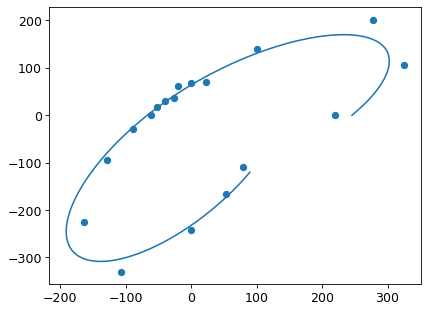

In [812]:
q_true = 1
ndim = 12
seed = np.random.randint(0, 100000)
track='orbit'
dict_data, params_data, spline_data, theta_track_data = get_mock_data(q_true, ndim, track=track, seed=seed, sigma=10, n_ang=72, min_particle=3, max_dist=80)

plt.scatter(dict_data['x'], dict_data['y'])

r_track_data = spline_data(theta_track_data)
x_track_data = r_track_data * np.cos(theta_track_data)
y_track_data = r_track_data * np.sin(theta_track_data)
plt.plot(x_track_data, y_track_data)

In [ ]:
orbit_log_likelihood_ndim12(params, dict_data)